In [25]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import itertools

from ms_entropy.file_io.msp_file import read_one_spectrum
import numba as nb
import pyteomics.mgf
import sys
import importlib

sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns
importlib.reload(sys.modules['create_spectrum'])
importlib.reload(sys.modules['reformat_columns'])
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns


In [63]:
QUERY_DIR = '../../data/mod_cosine_queries/'
QUERY_PATH = 's3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/'
DATA_DIR = '../../data/'

NAME_DICT = {'our_weights/weighted_filtered_10_ppm': 'Our weights 10 ppm',
             'our_weights/weighted_filtered_100_ppm': 'Our weights 100 ppm',
             'our_weights/weighted_filtered_5000_ppm': 'Our weights 5000 ppm',
             'no_weights/filtered_10_ppm': 'No weights 10 ppm',
             'no_weights/filtered_100_ppm': 'No weights 100 ppm',
             'no_weights/filtered_5000_ppm': 'No weights 5000 ppm',
             'Stein_weights_0.6_3/10_ppm_stein_weights_0.6_3': 'Stein weights 10 ppm',
             'Stein_weights_0.6_3/100_ppm_stein_weights_0.6_3': 'Stein weights 100 ppm',
             'Stein_weights_0.6_3/5000_ppm_stein_weights_0.6_3': 'Stein weights 5000 ppm',
             'Stein_weights_0.5_1/10_ppm_stein_weights_0.5_1': 'Sokolov weights 10 ppm',
             'Stein_weights_0.5_1/100_ppm_stein_weights_0.5_1': 'Sokolov weights 100 ppm',
             'Stein_weights_0.5_1/5000_ppm_stein_weights_0.5_1': 'Sokolov weights 5000 ppm'}

ALL_NAMES = NAME_DICT.values()
ALL_FILE_NAMES = NAME_DICT.keys()

CLASS_DICT = {NAME_DICT[file_name]: file_name.split('/')[0] for file_name in ALL_FILE_NAMES}


# Get queries

In [64]:
# Get the NIST23 queries
# queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
# weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}_with_stats.csv', index_col=0)
queries = {}
for i,name in tqdm(enumerate(ALL_FILE_NAMES)):
    try:
        queries[ NAME_DICT[name]] = pd.read_csv(f'{QUERY_DIR}{name}_with_stats.csv', index_col=0)
    except:
        queries[NAME_DICT[name]] = pd.read_csv(f'{QUERY_PATH}{name}_with_stats.csv', index_col=0)
    if i == 0:
        shared_queries = set(queries[NAME_DICT[name]].wout_identifier)
    else:
        shared_queries = shared_queries.intersection(set(queries[NAME_DICT[name]].wout_identifier))

# Filter the queries to only include queries in both the weighted and unweighted queries
for name in ALL_NAMES:
    queries[name] = queries[name][queries[name]['wout_identifier'].isin(shared_queries)]

12it [00:48,  4.01s/it]


In [65]:
# Reformat columns in the query dataframe
for name in ALL_NAMES:
    queries[name] = reformat_columns(['library_spectra_matches', 
                                'exact_matches', 
                                'nist_inchis', 
                                'smiles', 
                                'tanimoto'],
                                query_type='modified_cosine',
                                query_df=queries[name])

100%|██████████| 25437/25437 [00:01<00:00, 14146.35it/s]


# Look at number of matches

In [71]:
# Create dataframe for number of matches
num_matches = pd.DataFrame(columns=['num_queries_without_matches', 'average_num_matches', 'max_num_matches', 
                                    'average_num_exact_matches', 'num_queries_without_exact_matches'])

# Get number of matches per query for each weighting method
for name in ALL_NAMES:
    num_matches_list = queries[name].library_spectra_matches.apply(lambda x: len(x))
    num_exact_matches = queries[name].exact_matches.apply(lambda x: len(x))
    num_matches.loc[name.split('/')[-1]] = [len(num_matches_list[num_matches_list == 0]),
                                            num_matches_list.mean(),
                                            num_matches_list.max(),
                                            num_exact_matches.mean(),
                                            len(num_exact_matches[num_exact_matches == 0])]

num_matches['class'] = num_matches.index.map(CLASS_DICT)
num_matches

,num_queries_without_matches,average_num_matches,max_num_matches,average_num_exact_matches,num_queries_without_exact_matches,class
Our weights 10 ppm,2045.0,17.831859,226.0,9.605653,2470.0,our_weights
Our weights 100 ppm,1422.0,20.571490,234.0,9.775327,2032.0,our_weights
Our weights 5000 ppm,834.0,58.816802,687.0,9.775327,2032.0,our_weights
No weights 10 ppm,1994.0,15.424814,123.0,8.888194,2496.0,no_weights
No weights 100 ppm,1259.0,18.809883,139.0,9.062586,2047.0,no_weights
No weights 5000 ppm,503.0,60.073043,523.0,9.062586,2047.0,no_weights
Stein weights 10 ppm,2321.0,19.456264,193.0,8.929630,3238.0,Stein_weights_0.6_3
Stein weights 100 ppm,1324.0,31.192200,308.0,9.091520,2826.0,Stein_weights_0.6_3
Stein weights 5000 ppm,347.0,157.237843,1332.0,9.091520,2826.0,Stein_weights_0.6_3
Sokolov weights 10 ppm,1739.0,19.436923,217.0,10.113221,2231.0,Stein_weights_0.5_1


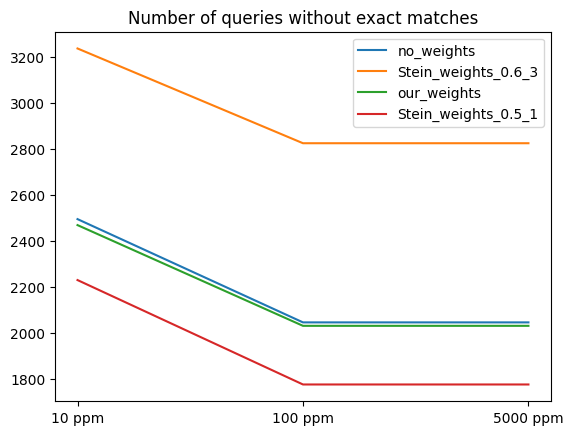

In [72]:
for c in set(num_matches['class']):
    current_df = num_matches[num_matches['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['num_queries_without_exact_matches'].values, label=c)

plt.title('Number of queries without exact matches')
plt.legend()


# Precision of top n matches

In [73]:
# Create data frame
column_names = ALL_NAMES
exact_matches_precision = pd.DataFrame(columns=column_names, 
                                        index=['top_1', 'top_5', 'top_10'])
n_vals = [1, 5, 10]

# Get precision of top n matches
for n in n_vals:
    for name in ALL_NAMES:
        exact_matches_precision.loc[f'top_{n}', name] =  queries[name]['exact_matches'].apply(lambda x: len(x[x < n])/n).mean()

exact_matches_precision = exact_matches_precision.T
exact_matches_precision['class'] = exact_matches_precision.index.map(CLASS_DICT)

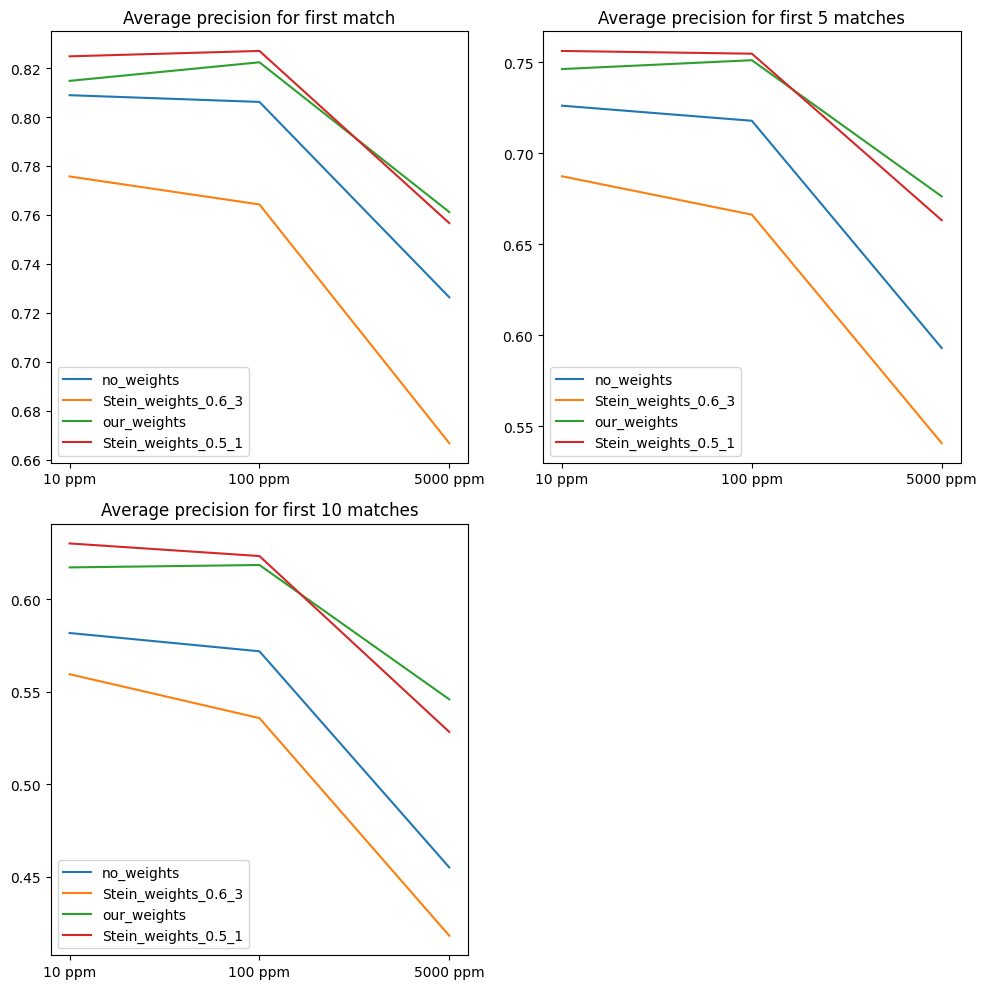

In [93]:
# PLot top 1
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for c in set(exact_matches_precision['class']):
    current_df = exact_matches_precision[exact_matches_precision['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['top_1'].values, label=c)
plt.title('Average precision for first match')
plt.legend()

# Plot top 5
plt.subplot(2,2,2)
for c in set(exact_matches_precision['class']):
    current_df = exact_matches_precision[exact_matches_precision['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['top_5'].values, label=c)
plt.title('Average precision for first 5 matches')
plt.legend()

# Plot top 10
plt.subplot(2,2,3)
for c in set(exact_matches_precision['class']):
    current_df = exact_matches_precision[exact_matches_precision['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['top_10'].values, label=c)
plt.title('Average precision for first 10 matches')
plt.legend()

plt.tight_layout()
plt.show()


# Tanimoto Scores

In [102]:
# Create data frame
column_names = ALL_NAMES
average_tanimoto_top_n = pd.DataFrame(columns=column_names, 
                                   index=['top_1', 'top_5', 'top_10'])
n_vals = [1, 5, 10]

# Calculate average tanimoto score for top n results
for n in n_vals:
    for name in ALL_NAMES:
        average_tanimoto_top_n.loc[f'top_{n}', name] = np.mean(list(itertools.chain.from_iterable([x[:n] for 
                                                                x in queries[name]['tanimoto'] if len(x) > 0])))

average_tanimoto_top_n = average_tanimoto_top_n.T
average_tanimoto_top_n['class'] = average_tanimoto_top_n.index.map(CLASS_DICT)

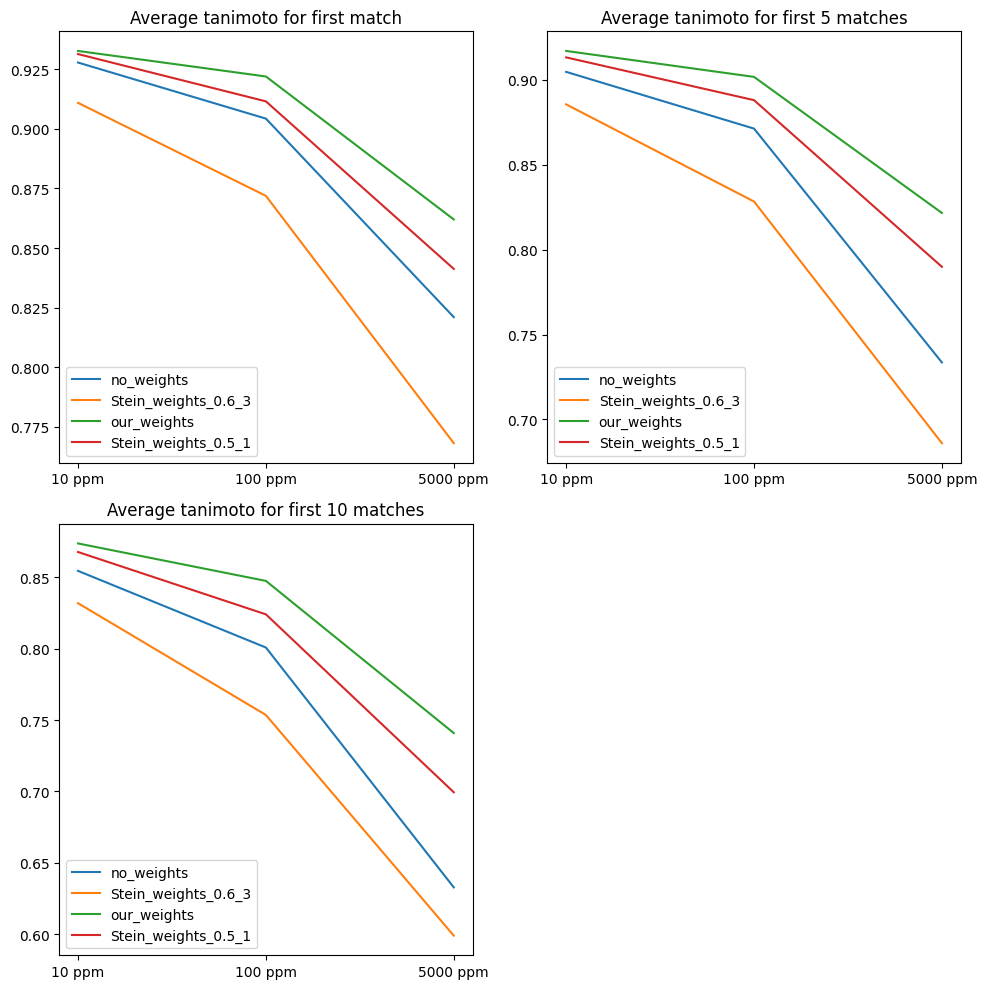

In [99]:
# PLot top 1
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for c in set(average_tanimoto_top_n['class']):
    current_df = average_tanimoto_top_n[average_tanimoto_top_n['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['top_1'].values, label=c)
plt.title('Average tanimoto for first match')
plt.legend()

# Plot top 5
plt.subplot(2,2,2)
for c in set(average_tanimoto_top_n['class']):
    current_df = average_tanimoto_top_n[average_tanimoto_top_n['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['top_5'].values, label=c)
plt.title('Average tanimoto for first 5 matches')
plt.legend()

# Plot top 10
plt.subplot(2,2,3)
for c in set(average_tanimoto_top_n['class']):
    current_df = average_tanimoto_top_n[average_tanimoto_top_n['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['top_10'].values, label=c)
plt.title('Average tanimoto for first 10 matches')
plt.legend()

plt.tight_layout()
plt.show()

# Thresholds

In [109]:

# Get number of matches above a threshold
thresholds = [0.5, 0.7, 0.9]
threshold_df = pd.DataFrame(columns=thresholds)
for threshold in thresholds:
    for name in ALL_NAMES:
        threshold_df.loc[name, threshold] = queries[name].library_spectra_matches.apply(lambda x: 
                                    len([y for y in x if y[1]> threshold])).mean()

threshold_df['class'] = threshold_df.index.map(CLASS_DICT)

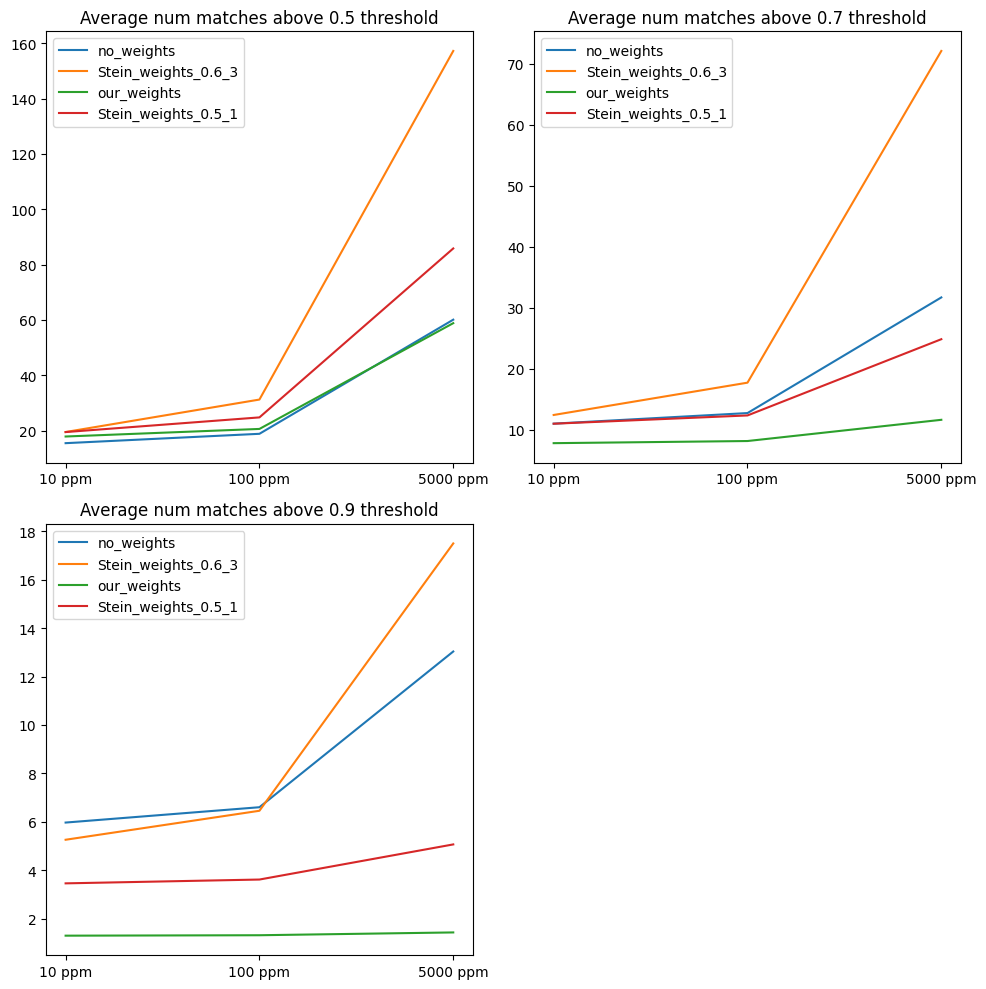

In [113]:
# PLot 0.5 threshold
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for c in set(threshold_df['class']):
    current_df = threshold_df[threshold_df['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df[0.5].values, label=c)
plt.title('Average num matches above 0.5 threshold')
plt.legend()

# Plot 0.7 threshold
plt.subplot(2,2,2)
for c in set(threshold_df['class']):
    current_df = threshold_df[threshold_df['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df[0.7].values, label=c)
plt.title('Average num matches above 0.7 threshold')
plt.legend()

# Plot 0.9 threshold
plt.subplot(2,2,3)
for c in set(threshold_df['class']):
    current_df = threshold_df[threshold_df['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df[0.9].values, label=c)
plt.title('Average num matches above 0.9 threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Look at AUC scores

In [114]:
auc_scores = pd.DataFrame(index=['avg_auc', 
                                   'num_zero_auc',
                                   'num_one_auc',
                                   'num_NaN_auc'],
                          columns=column_names)

for name in ALL_NAMES:
    auc_scores[name] = [queries[name].auc.mean(), 
                        queries[name].auc.loc[queries[name].auc == 0].count(), 
                        queries[name].auc.loc[queries[name].auc == 1].count(),
                        queries[name].auc.isna().sum()]

auc_scores = auc_scores.T
auc_scores['class'] = auc_scores.index.map(CLASS_DICT)

# # Create bar plot
# auc_scores.loc[['num_zero_auc','num_one_auc','num_NaN_auc']].plot.bar(figsize=(10,5), rot=0,
#                 color=['#eca86f', '#e96f3d', '#d73c24', '#0d2b53','#1d6d8b', '#2f8895', '#82a8a0'])
# plt.title('AUC scores')
# plt.ylabel('Average tanimoto score')
# plt.xlabel('n')
# plt.show()

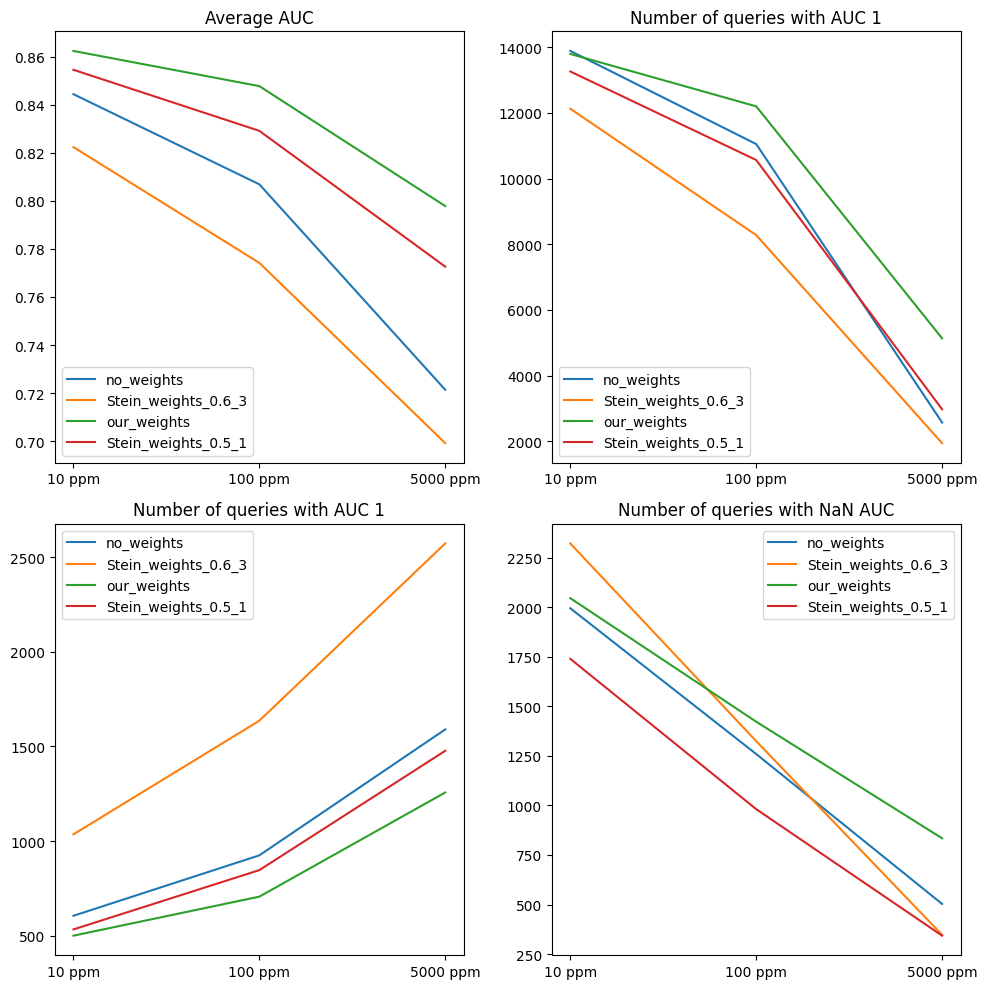

In [116]:
# PLot 0.5 threshold
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for c in set(auc_scores['class']):
    current_df = auc_scores[auc_scores['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['avg_auc'].values, label=c)
plt.title('Average AUC')
plt.legend()

# Plot 0.7 threshold
plt.subplot(2,2,2)
for c in set(auc_scores['class']):
    current_df = auc_scores[auc_scores['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['num_one_auc'].values, label=c)
plt.title('Number of queries with AUC 1')
plt.legend()

# Plot 0.9 threshold
plt.subplot(2,2,3)
for c in set(auc_scores['class']):
    current_df = auc_scores[auc_scores['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['num_zero_auc'].values, label=c)
plt.title('Number of queries with AUC 1')
plt.legend()

# Plot 0.9 threshold
plt.subplot(2,2,4)
for c in set(auc_scores['class']):
    current_df = auc_scores[auc_scores['class'] == c]
    plt.plot(['10 ppm','100 ppm','5000 ppm'],current_df['num_NaN_auc'].values, label=c)
plt.title('Number of queries with NaN AUC')
plt.legend()

plt.tight_layout()
plt.show()